<ipython-input-1-9dd05144528b>:17: DtypeWarning: Columns (19,59) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(r".\accepted_2007_to_2018Q4.csv",nrows=300000)
<ipython-input-1-9dd05144528b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)
<ipython-input-1-9dd05144528b>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_status'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0, 'Late (31-120 days)':0, 'Late (16-30 days)':0, 'Default':0})
<ipython-input-1-9dd05144528b>:35: Sett

New dataset has 266944 rows, and 19 columns.
Train and Test Size 186860, 80084
New dataset has 266944 rows, and 19 columns.
Train and Test Size 76655, 32853
New dataset has 266944 rows, and 19 columns.


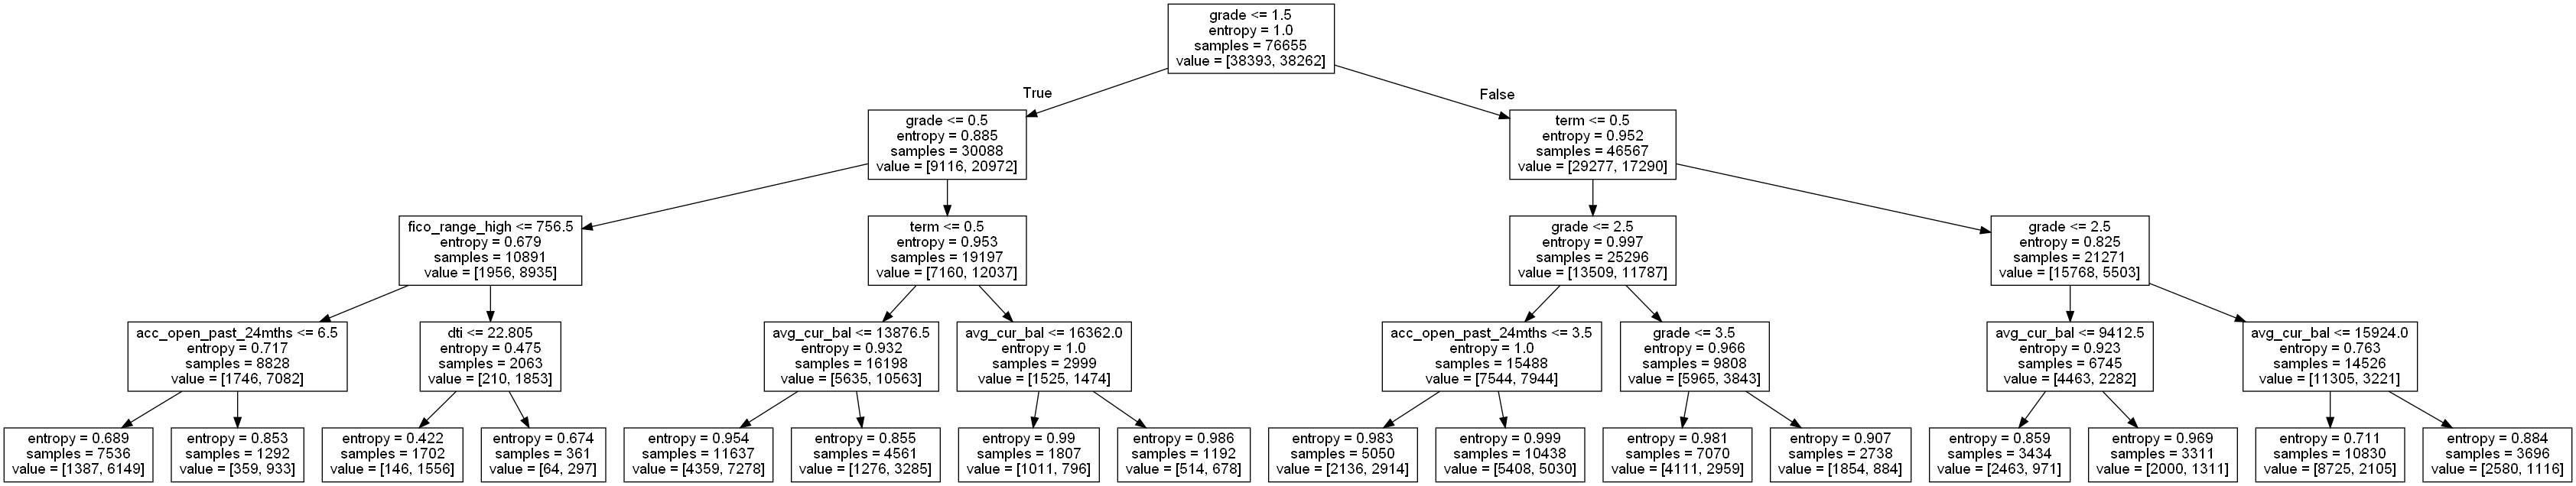

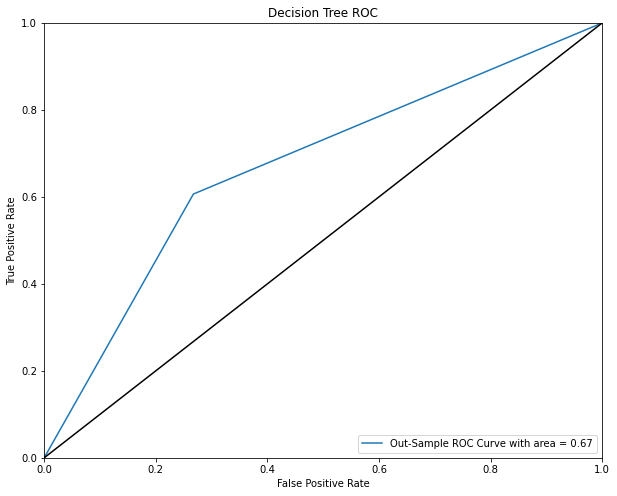

tn 11986 fp 4375 fn 6489 tp 10003
matrix [[11986  4375]
 [ 6489 10003]] accuracy 0.6693148266520561 precision 0.695715676728335 recall 0.6065365025466893 ROC 0.6695661548244723


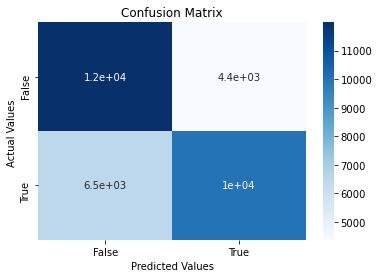

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
from sklearn import tree
import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
import pylab as pl
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score
from imblearn.under_sampling import RandomUnderSampler 
import seaborn as sns
"""## Load and clean data"""
df1 = pd.read_csv(r".\accepted_2007_to_2018Q4.csv",nrows=300000)
df1.head()
df1.set_index('id', inplace = True)

df=df1[['loan_amnt','term','grade','annual_inc','verification_status','dti',
        'delinq_2yrs','fico_range_high','inq_last_6mths','open_acc','pub_rec','revol_bal',\
        'revol_util','total_acc','avg_cur_bal','total_rev_hi_lim','acc_open_past_24mths','pct_tl_nvr_dlq','loan_status']]
# drop all rows with nan 
df.dropna(inplace = True)

# change predicting variables into 1 and 0
df = df[df['loan_status'].isin(['Fully Paid','Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default'])]
df['loan_status'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0, 'Late (31-120 days)':0, 'Late (16-30 days)':0, 'Default':0})

# convert all categorical values into numerical values
obj_df = df.select_dtypes(include=['object']).copy()
for name in obj_df.columns:
    if name != 'home_ownership':
        df[name] = df[name].astype('category').cat.codes
# new dataset size
print('New dataset has',len(df),'rows, and',len(df.columns),'columns.')

"""## Prepare training and testing dataset"""
# Define features and target
X = df.loc[:, df.columns != 'loan_status']      # Features
y = df['loan_status']                           # Target
# Splitting the datasets into training and testing data.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# Output the train and test data size
print(f"Train and Test Size {len(x_train)}, {len(x_test)}")
print('New dataset has',len(df),'rows, and',len(df.columns),'columns.')
#balance
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X, y = rus.fit_resample(X, y)
# Splitting the datasets into training and testing data.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Output the train and test data size
print(f"Train and Test Size {len(x_train)}, {len(x_test)}")
print('New dataset has',len(df),'rows, and',len(df.columns),'columns.')

def DecisionTree(x_train, x_test, y_train, y_test,feature_names,tree_depth):
    model = tree.DecisionTreeClassifier(max_depth = tree_depth,criterion='entropy')
    model.fit(x_train,y_train)
    #Mean accuracy of self.predict(X) wrt. y.
    # print("Training R-Square",model.score(x_train,y_train))
    # print("Testing R-Square",model.score(x_test,y_test))
    dot_data = tree.export_graphviz(model, out_file=None,feature_names=feature_names)
    graph = pydotplus.graphviz.graph_from_dot_data(dot_data)
    y_pred = model.predict(x_test)
    return graph,y_pred

def RandomForest(x_train, x_test, y_train, y_test,feature_names):
    model = RandomForestClassifier(n_estimators=1000)
    #np.ravel flattens the pandas Series into an np array. That's what the classifier needs
    model.fit(x_train,np.ravel(y_train))
    model.score(x_test,y_test)
    y_pred = model.predict(x_test)    
    importances = model.feature_importances_
    indices = np.argsort(importances)
    #编号10
    plt.figure(10,figsize=(10,10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    # plt.yticks(range(len(indices)),feature_names)
    plt.yticks(range(len(indices)),np.array(feature_names)[indices])
    plt.xlabel('Relative Importance')
    return y_pred

def Measure(y_true, y_pred,method,number):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred)
    recall=recall_score(y_true, y_pred)
    tn, fp, fn, tp=confusion_matrix(np.ravel(y_true),y_pred).ravel()
    matrix=confusion_matrix(np.ravel(y_true),y_pred)
    (fpr, tpr, thresholds) = roc_curve(y_true,y_pred)
    area = auc(fpr,tpr)
#     pl.clf() #Clear the current figure
    plt.figure(number,figsize=(10,8))
    pl.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)
    pl.plot([0, 1], [0, 1], 'k') #This plots the random (equal probability line)
    pl.xlim([0.0, 1.0])
    pl.ylim([0.0, 1.0])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(method+' ROC')
    pl.legend(loc="lower right")
    pl.show()
    print('tn',tn,'fp',fp,'fn',fn,'tp',tp)
    print('matrix',matrix,'accuracy',accuracy,'precision',precision,'recall',recall,'ROC',area)
    
    #plot confusion matrix
    plt.figure(number*3)
    ax = sns.heatmap(matrix, annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()
    return matrix,accuracy,precision,recall
    
feature_names = [key for key in df if not key=='loan_status']

graph,y_pred=DecisionTree(x_train, x_test, y_train, y_test,feature_names,4)
display(Image(graph.create_png()))
matrix,accuracy,precision,recall=Measure(y_test, y_pred,'Decision Tree',0)


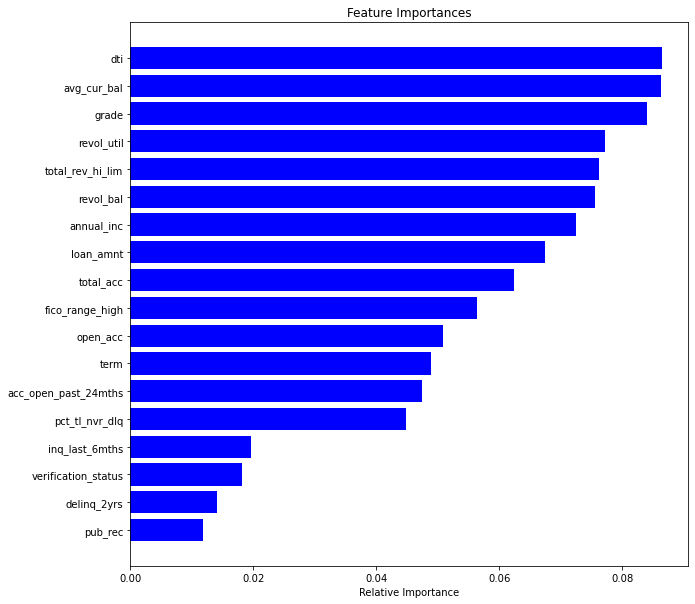

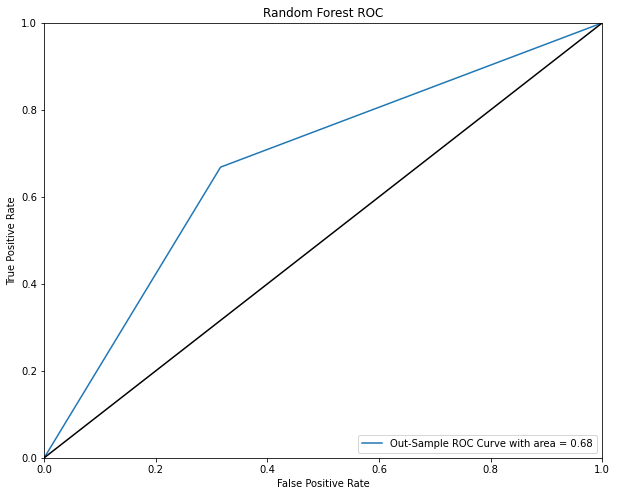

tn 11190 fp 5171 fn 5469 tp 11023
matrix [[11190  5171]
 [ 5469 11023]] accuracy 0.6761330776489209 precision 0.6806842040261826 recall 0.6683846713558089 ROC 0.6761640977951344


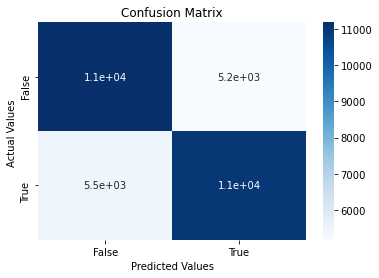

In [2]:
# from sklearn.model_selection import GridSearchCV
# parameters = {
#      'n_estimators':(100,500,1000), #the number of trees
#      'max_depth':(4,5,6,8),
#      'min_samples_split':(2,4,8),
#      'min_samples_leaf': (4,8,12,16)
# }

# model = GridSearchCV(RandomForestClassifier(),parameters,cv=3)
# model.fit(x_train, np.ravel(y_train))
# model.best_score_, model.best_params_

y_pred=RandomForest(x_train, x_test, y_train, y_test,feature_names)
matrix1,accuracy1,precision1,recall1=Measure(y_test, y_pred,'Random Forest',1)